In [ ]:
# !pip install pretrainedmodels==0.7.4
# !pip install efficientnet-pytorch==0.6.3
# !pip install timm==0.3.2

In [3]:
!nvidia-smi

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
from tqdm import tqdm

import sys
sys.path.append(os.path.abspath('/workspace/sunggu'))
sys.path.append(os.path.abspath('/workspace/sunggu/MONAI'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img/pix2pixHD'))

from sunggu_utils import check_value, take_list, plot_confusion_matrix, list_sort_nicely, find_dir, plot_3D

Tue Mar 30 08:34:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           On   | 00000000:1B:00.0 Off |                  N/A |
| 41%   31C    P8    17W / 280W |      1MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           On   | 00000000:1C:00.0 Off |                  N/A |
| 40%   

## Setup imports

In [4]:
import glob
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
import skimage
import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, GeneralizedDiceLoss, FocalLoss, TverskyLoss
from monai.metrics import compute_meandice, DiceMetric, ConfusionMatrixMetric 
from monai.networks.layers import Norm
from monai.networks.nets import UNet, highresnet
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadNiftid,
    LoadNumpyd,
    Orientationd,
    ScaleIntensityRanged,
    Spacingd,
    Lambdad,
    ToTensord,
    CastToTyped,
    DeleteItemsd,
    AsDiscrete,
    SpatialPadd,
    CenterSpatialCropd,
    RandSpatialCropd,
    Resized,
)
from monai.utils import first, set_determinism

print_config()

MONAI version: 0+unknown
Python version: 3.6.9 (default, Oct  8 2020, 12:12:24)  [GCC 8.4.0]
OS version: Linux (4.15.0-135-generic)
Numpy version: 1.19.5
Pytorch version: 1.8.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.1.2
Tensorboard version: 2.4.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.7.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.59.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set 시드

In [5]:
import random

random_seed = 7
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

set_determinism(seed=7)

## Set Train / Test

In [6]:
train_low_images  = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Train/noise20_b50f_5.0/*/*.npy'))
train_high_images = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Train/noise100_b50f_5.0/*/*.npy'))

valid_low_images  = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Valid/noise20_b50f_5.0/*/*.npy'))
valid_high_images = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Valid/noise100_b50f_5.0/*/*.npy'))

total_low_list  = train_low_images  + valid_low_images
total_high_list = train_high_images + valid_high_images

train_files = [{"low": low_name, "high": high_name} for low_name, high_name in zip(total_low_list, total_high_list)]

## Augmentation

In [7]:
# CT에 맞는 Augmentation
from torchvision import transforms
train_transforms = Compose(
    [
        LoadNumpyd(keys=["low", "high"]),
        AddChanneld(keys=["low", "high"]), 
        Resized(keys=["low", "high"], spatial_size=(256, 256), mode='bicubic', align_corners=True),
        ToTensord(keys=["low", "high"]),
        Lambdad(keys=["low", "high"], func=transforms.Normalize(mean=(0.5), std=(0.5))),
    ]
)

## Check transforms in DataLoader

In [8]:
def visual_windowing(x):
    x = (x * 0.5) + 0.5 
    x = np.clip(x, a_min=0.250, a_max=0.270)
    x -= x.min()
    x /= x.max()  
    
    return x

/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Train/noise20_b50f_5.0/HUH_JEO_F79/HUH_JEO_F79_001_20210218_184354_00026.npy
/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Train/noise100_b50f_5.0/HUH_JEO_F79/HUH_JEO_F79_001_20210218_184251_00026.npy
image shape: torch.Size([256, 256])


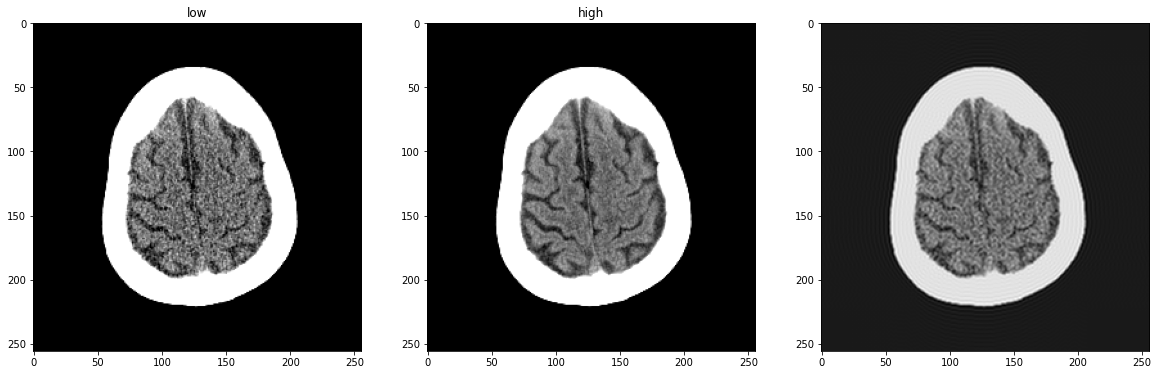

In [31]:
check_ds = Dataset(data=train_files, transform=train_transforms)
# check_loader = DataLoader(check_ds, batch_size=1, shuffle=False)
# check_data = next(iter(check_loader))

check_data = check_ds[160]

print(check_data['low_meta_dict']['filename_or_obj'])
print(check_data['high_meta_dict']['filename_or_obj'])

low = (check_data["low"][0])
high = (check_data["high"][0])
print(f"image shape: {low.shape}")

plt.figure("check", (20, 14))
plt.subplot(1, 3, 1)
plt.title("low")
plt.imshow(visual_windowing(low), cmap="gray")

plt.subplot(1, 3, 2)
plt.title("high")
plt.imshow(visual_windowing(high), cmap="gray")

plt.subplot(1, 3, 3)
k = lowpass_torch(visual_windowing(low), 0.3)
plt.imshow(k, 'gray')

plt.show()

In [10]:
import torch
import torch.fft as fft

def lowpass_torch(input, limit):
    pass1 = torch.abs(fft.rfftfreq(input.shape[-1])) < limit
    pass2 = torch.abs(fft.fftfreq(input.shape[-2])) < limit
    kernel = torch.outer(pass2, pass1)
    
    fft_input = fft.rfft2(input)
    return fft.irfft2(fft_input * kernel, s=input.shape[-2:])

In [46]:
fft.fftfreq(10)

tensor([ 0.0000,  0.1000,  0.2000,  0.3000,  0.4000, -0.5000, -0.4000, -0.3000,
        -0.2000, -0.1000])

In [33]:
input = visual_windowing(low)
limit = 0.3
pass1 = torch.abs(fft.rfftfreq(input.shape[-1])) < limit
pass2 = torch.abs(fft.fftfreq(input.shape[-2])) < limit
kernel = torch.outer(pass2, pass1)

fft_input = fft.rfft2(input)
re = fft.irfft2(fft_input * kernel, s=input.shape[-2:])

In [39]:
fft.fftfreq(input.shape[-2]).shape

torch.Size([256])

In [37]:
input.shape

torch.Size([256, 256])

In [35]:
kernel.shape

torch.Size([256, 129])

In [36]:
fft_input.shape

torch.Size([256, 129])

In [23]:
k = lowpass_torch(visual_windowing(low), 0.4)
plt.imshow(k, 'gray')

In [11]:
visual_windowing(low).shape

torch.Size([256, 256])

In [16]:
q = fft.rfftfreq(visual_windowing(low).shape[-1])

In [22]:
q.m()

tensor(0.)

In [19]:
a = np.mgrid[:5, :5][0]
a.shape

(5, 5)

In [ ]:
torch.abs(fft.rfftfreq(visual_windowing(low).shape[-1])) < 

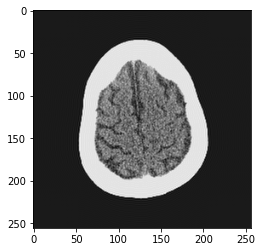

In [24]:
plt.imshow(k, 'gray')

In [ ]:
import multiprocessing
# from torchsampler.imbalanced import ImbalancedDatasetSampler, sunggu_ImbalancedDatasetSampler

# cf) use batch_size=2 to load images and use RandCropByPosNegLabeld
print("CPU 갯수 = ", multiprocessing.cpu_count())

# Cachedataset 이거 뭔가 문제가 있음...
train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=40, shuffle=True, num_workers=12, drop_last=True)

## Create Model, Loss, Optimizer  Only Low -> High

In [ ]:
def init_net_multi_gpu(net):
    net = torch.nn.DataParallel(net)
    net.to('cuda')        
    return net

def init_net_sigle_gpu(net):
    net.to('cuda')        
    return net

In [ ]:
from pix2pixHD.models import networks

device = 'cuda'

# 먼저 256x256 모델
netG = networks.define_G(input_nc=1, 
                         output_nc=1, 
                         ngf=64, 
                         netG='global', 
                         n_downsample_global=4, 
                         n_blocks_global=9, 
                         n_local_enhancers=1, 
                         n_blocks_local=3, 
                         norm='instance')      

netD = networks.define_D(input_nc=2, 
                         ndf=64,
                         n_layers_D=3,
                         norm='instance',
                         use_sigmoid=False, 
                         num_D=2, 
                         getIntermFeat=True)

# multi-gpu 사용
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    netG  = init_net_multi_gpu(netG)
    netD  = init_net_multi_gpu(netD)

else :
    netG  = init_net_sigle_gpu(netG)
    netD  = init_net_sigle_gpu(netD)

In [ ]:
# from torchsummary import summary
# input_size = (1,32,320,320)
# summary(model.encoder, input_size, batch_size=-1, device='cpu')

## 모델 이어서 학습하기

In [ ]:
## 네트워크 불러오기
checkpoint_dir = '/workspace/sunggu/4.Dose_img2img/model/Pix2Pix_2D_HD_256x256_global/epoch_980_model.pth'
checkpoint = torch.load(checkpoint_dir)

epoch = checkpoint['epoch']
netG.load_state_dict(checkpoint['netG_state_dict'])
netD.load_state_dict(checkpoint['netD_state_dict'])

## multi-gpu 사용
if torch.cuda.device_count() > 1:
    netG = torch.nn.DataParallel(netG)
    netD = torch.nn.DataParallel(netD)
    
netG.to('cuda')  
netD.to('cuda')  

print(epoch)

###### 필요한 Weight만 Load

In [ ]:
# # Before
# model_dict = model.state_dict()
# print("이전 weight = ", model_dict['encoder._conv_stem.weight'][0])

# load_dir = '/workspace/sunggu/1.Hemorrhage/monai_experiment/model/Efficient3d_conv2d_Aux/'
# pretrained_dict =  torch.load(os.path.join(load_dir, "epoch_0_best_metric_model.pth")) 

# # 1. filter out unnecessary keys
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# # 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# # 3. load the new state dict
# model.load_state_dict(model_dict)

# # After
# print("이후 weight = ", model_dict['encoder._conv_stem.weight'][0])

## 손실함수 정의하기

In [ ]:
# define loss functions
GAN_loss           = torch.nn.MSELoss()   # vanila nn.BCELoss()
FM_loss            = torch.nn.L1Loss()
Perceptual_loss    = networks.VGGLoss(device='cuda')

learning_rate = 2e-4
max_epochs = 1000

# Optimizer 설정하기
G_params  = list(netG.parameters())
D_params  = list(netD.parameters())    

optimizer_G = torch.optim.Adam(G_params, lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D_params, lr=learning_rate, betas=(0.5, 0.999))

def lambda_rule(epoch, start_decay_epoch=100, total_epoch=max_epochs):
    lr = 1.0 - max(0, epoch - start_decay_epoch) / float(total_epoch)
    return lr

scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_rule)
scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=lambda_rule)

# Generated image pool
from Cyclegan_sunggu.image_pool import ImagePool
num_pool = 0
fake_pool = ImagePool(num_pool)

In [ ]:
optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])

scheduler_G.load_state_dict(checkpoint['scheduler_G'])        
scheduler_D.load_state_dict(checkpoint['scheduler_D'])      

In [ ]:
print(checkpoint['epoch'])

## Train

In [ ]:
## 그밖에 부수적인 functions 설정하기
fn_tonumpy        = lambda x: x.cpu().detach().numpy().transpose(0, 2, 3, 1)
fn_denorm         = lambda x: (x * 0.5) + 0.5
fn_denorm_window  = visual_windowing

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from monai.visualize import plot_2d_or_3d_image

## 네트워크 학습시키기
epoch_num = 1000
val_interval = 10

epoch_train_loss_list = list()
epoch_val_loss_list   = list()

epoch_train_metric_list = list()
epoch_val_metric_list   = list()

writer = SummaryWriter(log_dir='/workspace/sunggu/4.Dose_img2img/runs/Pix2Pix_2D_HD_256x256_global')
root_dir = '/workspace/sunggu/4.Dose_img2img/model/Pix2Pix_2D_HD_256x256_global/'

low2high_png_dir = '/workspace/sunggu/4.Dose_img2img/Predictions/png/'+'Pix2Pix_2D_HD_256x256_global'+'/low2high/'

# 모델 save폴더 만들기
os.makedirs(root_dir, mode=0o777, exist_ok=True)
os.makedirs(low2high_png_dir, mode=0o777, exist_ok=True)

for epoch in range(981, epoch_num):
    print("-" * 10)
    print(f"epoch {epoch}/{epoch_num}")
    
    # Model 선언
    netG.train()    
    netD.train()
    
    # Loss 선언    
    loss_D_real_train = []
    loss_D_fake_train = []
    loss_G_gan_train         = []
    loss_G_fm_train          = []
    loss_G_vgg_train  = []    
    
    train_iterator = tqdm(train_loader, desc='Train', file=sys.stdout)    
    for batch_data in train_iterator:
        
        input_low  = batch_data['low'].to(device)
        input_high = batch_data['high'].to(device)
        
        # Generate fake
        output = netG(input_low)
        real = torch.cat([input_low, input_high], dim=1)
        fake = torch.cat([input_low, output], dim=1)        
        
        # Train Discriminator
        optimizer_D.zero_grad()
        
        pred_real = netD(real)    
        # POOL
        fake = fake_pool.query(fake)
        pred_fake = netD(fake.detach())  # Detach...!
        
        loss_D_real = torch.stack([GAN_loss(r_pred[-1], torch.ones_like(r_pred[-1]))  for r_pred in pred_real]).sum()
        loss_D_fake = torch.stack([GAN_loss(f_pred[-1], torch.zeros_like(f_pred[-1])) for f_pred in pred_fake]).sum()
        
        loss_D      = 0.5 * (loss_D_real + loss_D_fake)
        
        loss_D.backward()
        optimizer_D.step()

        
        # Train Generator        
        optimizer_G.zero_grad()
        
        pred_fake = netD(fake)        
        
            # Loss 1
        loss_G_gan = torch.stack([GAN_loss(f_pred[-1], torch.ones_like(f_pred[-1])) for f_pred in pred_fake]).sum()
        
            # Loss 2
        loss_G_fm = 0
        feat_weights = 4.0 / (netD.n_layers+1)
        D_weights = 1.0 / netD.num_D
        for i in range(netD.num_D):
            for j in range(len(pred_fake[i])-1):
                loss_G_fm += D_weights * feat_weights * FM_loss(pred_fake[i][j], pred_real[i][j].detach()) * 10
            # Loss 3                       
        loss_G_vgg = Perceptual_loss(output.repeat(1,3,1,1), input_high.repeat(1,3,1,1)) * 10

        loss_G     = loss_G_gan + loss_G_fm + loss_G_vgg
        loss_G.backward()
        optimizer_G.step()
        
        # 기록
        loss_D_real_train  += [loss_D_real.item()]
        loss_D_fake_train  += [loss_D_fake.item()]
        loss_G_gan_train   += [loss_G_gan.item()]
        loss_G_fm_train    += [loss_G_fm.item()]
        loss_G_vgg_train   += [loss_G_vgg.item()]

        
    print( "Generator Loss       [Gan Loss]    = %.4f" %np.mean(loss_G_gan_train) ) 
    print( "Generator Loss       [FM  Loss]    = %.4f" %np.mean(loss_G_fm_train) ) 
    print( "Generator Loss       [VGG Loss]    = %.4f" %np.mean(loss_G_vgg_train) ) 
    print( "Discriminator Loss   [Real]        = %.4f" %np.mean(loss_D_real_train) )
    print( "Discriminator Loss   [Fake]        = %.4f" %np.mean(loss_D_fake_train) )
    
    
    # Tensorboard 저장하기
    input_low   = fn_denorm_window(fn_tonumpy((input_low)))
    input_high  = fn_denorm_window(fn_tonumpy((input_high)))
    output      = fn_denorm_window(fn_tonumpy((output)))

    input_low   = np.clip(input_low, a_min=0, a_max=1)
    input_high  = np.clip(input_high, a_min=0, a_max=1)
    output      = np.clip(output, a_min=0, a_max=1)

    # png Save
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_low.png',   input_low[0].squeeze(),   cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_output_high.png', output[0].squeeze(),      cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_ground_high.png', input_high[0].squeeze(),  cmap="gray")
    
    # Loss Write    
    writer.add_scalar('Train/loss_G_gan',  np.mean(loss_G_gan_train), epoch)
    writer.add_scalar('Train/loss_G_fm',   np.mean(loss_G_fm_train), epoch)
    writer.add_scalar('Train/loss_G_vgg',  np.mean(loss_G_vgg_train), epoch)
    writer.add_scalar('Train/loss_D_real', np.mean(loss_D_real_train), epoch)
    writer.add_scalar('Train/loss_D_fake', np.mean(loss_D_fake_train), epoch)    
    
    # 저장
    if epoch % 5 == 0 or epoch == epoch_num:

        if torch.cuda.device_count() > 1:
            checkpoint = {'epoch': epoch, 
                          'netG_state_dict': netG.module.state_dict(), 
                          'netD_state_dict': netD.module.state_dict(), 
                          'optimizer_G_state_dict': optimizer_G.state_dict(),
                          'optimizer_D_state_dict': optimizer_D.state_dict(),  
                          'scheduler_G': scheduler_G.state_dict(),
                          'scheduler_D': scheduler_D.state_dict(),
                         }                    

        else:
            checkpoint = {'epoch': epoch, 
                          'netG_state_dict': netG.state_dict(), 
                          'netD_state_dict': netD.state_dict(), 
                          'optimizer_G_state_dict': optimizer_G.state_dict(),
                          'optimizer_D_state_dict': optimizer_D.state_dict(),
                          'scheduler_G': scheduler_G.state_dict(),
                          'scheduler_D': scheduler_D.state_dict(),
                         }                         

            torch.save(checkpoint, os.path.join(root_dir, "epoch_" + str(epoch) + "_model.pth"))        
    
    # Scheduler
    writer.add_scalar('lr', optimizer_G.param_groups[0]['lr'], epoch)
    old_lr = optimizer_G.param_groups[0]['lr']
    lr = optimizer_G.param_groups[0]['lr']
    print('Learning Rate %.10f -> %.10f' % (old_lr, lr))

    scheduler_G.step()    
    scheduler_D.step()    

writer.close()    

In [ ]:

if torch.cuda.device_count() > 1:
    checkpoint = {'epoch': epoch, 
                  'netG_state_dict': netG.module.state_dict(), 
                  'netD_state_dict': netD.module.state_dict(), 
                  'optimizer_G_state_dict': optimizer_G.state_dict(),
                  'optimizer_D_state_dict': optimizer_D.state_dict(),  
                  'scheduler_G': scheduler_G.state_dict(),
                  'scheduler_D': scheduler_D.state_dict(),
                 }                    

else:
    checkpoint = {'epoch': epoch, 
                  'netG_state_dict': netG.state_dict(), 
                  'netD_state_dict': netD.state_dict(), 
                  'optimizer_G_state_dict': optimizer_G.state_dict(),
                  'optimizer_D_state_dict': optimizer_D.state_dict(),
                  'scheduler_G': scheduler_G.state_dict(),
                  'scheduler_D': scheduler_D.state_dict(),
                 }                         

    torch.save(checkpoint, os.path.join(root_dir, "epoch_" + str(epoch) + "_last_model.pth"))   

In [ ]:
epoch

## TEST

In [ ]:
#     with torch.no_grad():
#         netG.eval()
#         netD.eval()

#         loss_G_gan_valid  = []
#         loss_G_L1_valid   = []
#         loss_D_real_valid = []
#         loss_D_fake_valid = []
        
#         valid_iterator = tqdm(valid_loader, desc='Valid', file=sys.stdout)    
#         for batch_data in valid_iterator:
        
#             input_low  = batch_data['low'].to(device)
#             input_high = batch_data['high'].to(device)
            
#             output = netG(input_low)

#             real = torch.cat([input_low, input_high], dim=1)
#             fake = torch.cat([input_low, output], dim=1)      
            
#             # D
#             pred_real = netD(real)        
#             pred_fake = netD(fake.detach())

#             loss_D_real = gan_loss(pred_real, torch.ones_like(pred_real))
#             loss_D_fake = gan_loss(pred_fake, torch.zeros_like(pred_fake))

#             # G
#             pred_fake = netD(fake)        
            
#             loss_G_gan = gan_loss(pred_fake, torch.ones_like(pred_fake))
#             loss_G_L1  = L1_loss(output, input_high)

#             # 기록
#             loss_D_real_valid += [loss_D_real.item()]
#             loss_D_fake_valid += [loss_D_fake.item()]
#             loss_G_gan_valid  += [loss_G_gan.item()]
#             loss_G_L1_valid   += [loss_G_L1.item()]
        
        
#     print( "Generator Loss       [Gan Loss]    = %.4f" %np.mean(loss_G_gan_valid) ) 
#     print( "Generator Loss       [L1  Loss]    = %.4f" %np.mean(loss_G_L1_valid) ) 
#     print( "Discriminator Loss   [Real]        = %.4f" %np.mean(loss_D_real_valid) )
#     print( "Discriminator Loss   [Fake]        = %.4f" %np.mean(loss_D_fake_valid) )

    
#     # Tensorboard 저장하기
#     input_low   = fn_denorm(fn_tonumpy((input_low)))
#     input_high  = fn_denorm(fn_tonumpy((input_high)))
#     output = fn_denorm(fn_tonumpy((output)))

#     input_low   = np.clip(input_low, a_min=0, a_max=1)
#     input_high  = np.clip(input_high, a_min=0, a_max=1)
#     output = np.clip(output, a_min=0, a_max=1)

#     # png Save
#     plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_low.png',   input_low[0].squeeze(),   cmap="gray")
#     plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_output_high.png', output[0].squeeze(), cmap="gray")
#     plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_ground_high.png', input_high[0].squeeze(),  cmap="gray")
    
#     # Loss Write    
#     writer.add_scalar('Valid/loss_G_gan',  np.mean(loss_G_gan_valid), epoch)
#     writer.add_scalar('Valid/loss_G_L1',   np.mean(loss_G_L1_valid), epoch)
#     writer.add_scalar('Valid/loss_D_real', np.mean(loss_D_real_valid), epoch)
#     writer.add_scalar('Valid/loss_D_fake', np.mean(loss_D_fake_valid), epoch)

    
#     # 저장
#     if epoch % 5 == 0 or epoch == epoch_num:

#         if torch.cuda.device_count() > 1:
#             checkpoint = {'epoch': epoch, 
#                           'netG_state_dict': netG.module.state_dict(), 
#                           'netD_state_dict': netD.module.state_dict(), 
#                           'optimizer_G_state_dict': optimizer_G.state_dict(),
#                           'optimizer_D_state_dict': optimizer_D.state_dict(),  
#                           'scheduler_G': scheduler_G.state_dict(),
#                           'scheduler_D': scheduler_D.state_dict(),
#                          }                    

#         else:
#             checkpoint = {'epoch': epoch, 
#                           'netG_state_dict': netG.state_dict(), 
#                           'netD_state_dict': netD.state_dict(), 
#                           'optimizer_G_state_dict': optimizer_G.state_dict(),
#                           'optimizer_D_state_dict': optimizer_D.state_dict(),
#                           'scheduler_G': scheduler_G.state_dict(),
#                           'scheduler_D': scheduler_D.state_dict(),
#                          }                         

#             torch.save(checkpoint, os.path.join(root_dir, "epoch_" + str(epoch) + "_model.pth"))        
    
#     # Scheduler
#     writer.add_scalar('lr', optimizer_G.param_groups[0]['lr'], epoch)      
#     old_lr = optimizer_G.param_groups[0]['lr']
#     lr = optimizer_G.param_groups[0]['lr']
#     print('Learning Rate %.10f -> %.10f' % (old_lr, lr))

#     scheduler_G.step()    
#     scheduler_D.step()    

# writer.close()

In [ ]:
def diagnose_network(net, name='network'):
    """Calculate and print the mean of average absolute(gradients)
    Parameters:
        net (torch network) -- Torch network
        name (str) -- the name of the network
    """
    mean = 0.0
    count = 0
    for param in net.parameters():
        if param.grad is not None:
            mean += torch.mean(torch.abs(param.grad.data))
            count += 1
    if count > 0:
        mean = mean / count
    print(name)
    print(mean)